In [26]:
!pip install pandas numpy matplotlib seaborn scipy scikit-learn pingouin

^C


In [4]:
# mHealth Dataset Analysis: Heart Rate & Acceleration Study
# Complete Data Cleaning, Exploration, and Hypothesis Testing

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import f_oneway, ttest_ind
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("=" * 80)
print("mHealth Dataset Analysis - Body Motion and Vital Signs Study")
print("=" * 80)

mHealth Dataset Analysis - Body Motion and Vital Signs Study


In [5]:
print("\n[1] LOADING DATA FROM ALL SUBJECTS")
print("-" * 80)

# Column names based on documentation
column_names = [
    'chest_acc_x', 'chest_acc_y', 'chest_acc_z',
    'ecg_lead1', 'ecg_lead2',
    'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z',
    'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z',
    'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
    'arm_acc_x', 'arm_acc_y', 'arm_acc_z',
    'arm_gyro_x', 'arm_gyro_y', 'arm_gyro_z',
    'arm_mag_x', 'arm_mag_y', 'arm_mag_z',
    'activity_label'
]

# Activity mapping
activity_map = {
    0: 'Null',
    1: 'Standing still',
    2: 'Sitting and relaxing',
    3: 'Lying down',
    4: 'Walking',
    5: 'Climbing stairs',
    6: 'Waist bends forward',
    7: 'Frontal elevation of arms',
    8: 'Knees bending',
    9: 'Cycling',
    10: 'Jogging',
    11: 'Running',
    12: 'Jump front & back'
}

# Load all subject files
all_data = []
subject_ids = range(1, 11)  # 10 subjects

for subject_id in subject_ids:
    try:
        filename = f'mHealth_subject{subject_id}.log'
        df = pd.read_csv(filename, sep='\t', header=None, names=column_names)
        df['subject_id'] = subject_id
        all_data.append(df)
        print(f"✓ Loaded subject {subject_id}: {len(df):,} samples")
    except FileNotFoundError:
        print(f"✗ File not found: {filename}")

# Combine all data
if all_data:
    data = pd.concat(all_data, ignore_index=True)
    print(f"\n✓ Total samples loaded: {len(data):,}")
    print(f"✓ Total subjects: {len(data['subject_id'].unique())}")
else:
    print("ERROR: No data files found. Please upload mHealth_subject*.log files.")


[1] LOADING DATA FROM ALL SUBJECTS
--------------------------------------------------------------------------------
✓ Loaded subject 1: 161,280 samples
✓ Loaded subject 2: 130,561 samples
✓ Loaded subject 3: 122,112 samples
✓ Loaded subject 4: 116,736 samples
✓ Loaded subject 5: 119,808 samples
✓ Loaded subject 6: 98,304 samples
✓ Loaded subject 7: 104,448 samples
✓ Loaded subject 8: 129,024 samples
✓ Loaded subject 9: 135,168 samples
✓ Loaded subject 10: 98,304 samples

✓ Total samples loaded: 1,215,745
✓ Total subjects: 10


In [6]:
# Check data structure
print("\nDataset Info:")
print(f"Shape: {data.shape}")
print(f"\nFirst few rows:")
print(data.head())

print(f"\nData types:")
print(data.dtypes)

print(f"\nBasic statistics:")
print(data.describe())


Dataset Info:
Shape: (1215745, 25)

First few rows:
   chest_acc_x  chest_acc_y  chest_acc_z  ecg_lead1  ecg_lead2  ankle_acc_x  \
0      -9.8184     0.009971      0.29563   0.004186   0.004186       2.1849   
1      -9.8489     0.524040      0.37348   0.004186   0.016745       2.3876   
2      -9.6602     0.181850      0.43742   0.016745   0.037677       2.4086   
3      -9.6507     0.214220      0.24033   0.079540   0.117220       2.1814   
4      -9.7030     0.303890      0.31156   0.221870   0.205130       2.4173   

   ankle_acc_y  ankle_acc_z  ankle_gyro_x  ankle_gyro_y  ...  arm_acc_y  \
0      -9.6967      0.63077      0.103900      -0.84053  ...    -4.5781   
1      -9.5080      0.68389      0.085343      -0.83865  ...    -4.3198   
2      -9.5674      0.68113      0.085343      -0.83865  ...    -4.2772   
3      -9.4301      0.55031      0.085343      -0.83865  ...    -4.3163   
4      -9.3889      0.71098      0.085343      -0.83865  ...    -4.1459   

   arm_acc_z  arm_gyr

In [7]:
print("\n[2] DATA CLEANING")
print("-" * 80)

# Check for missing values
print("Missing values per column:")
missing_counts = data.isnull().sum()
print(missing_counts)

total_missing = missing_counts.sum()
if total_missing > 0:
    print(f"\nTotal missing values: {total_missing:,}")

    # Imputation strategy for missing values
    # For sensor data, we'll use forward fill (carry forward last valid observation)
    sensor_cols = [col for col in data.columns if col not in ['activity_label', 'subject_id']]

    print("\nImputing missing values using forward fill method...")
    data[sensor_cols] = data[sensor_cols].fillna(method='ffill')

    # If still missing (at the beginning), use backward fill
    data[sensor_cols] = data[sensor_cols].fillna(method='bfill')

    print("✓ Missing values imputed")
else:
    print("✓ No missing values found")

# Verify no missing values remain
print(f"\nRemaining missing values: {data.isnull().sum().sum()}")


[2] DATA CLEANING
--------------------------------------------------------------------------------
Missing values per column:
chest_acc_x       0
chest_acc_y       0
chest_acc_z       0
ecg_lead1         0
ecg_lead2         0
ankle_acc_x       0
ankle_acc_y       0
ankle_acc_z       0
ankle_gyro_x      0
ankle_gyro_y      0
ankle_gyro_z      0
ankle_mag_x       0
ankle_mag_y       0
ankle_mag_z       0
arm_acc_x         0
arm_acc_y         0
arm_acc_z         0
arm_gyro_x        0
arm_gyro_y        0
arm_gyro_z        0
arm_mag_x         0
arm_mag_y         0
arm_mag_z         0
activity_label    0
subject_id        0
dtype: int64
✓ No missing values found

Remaining missing values: 0


In [8]:
# Remove null class (label 0)
print("\nRemoving null class (activity_label = 0)...")
initial_len = len(data)
data_clean = data[data['activity_label'] != 0].copy()
print(f"✓ Removed {initial_len - len(data_clean):,} null class samples")
print(f"Remaining samples: {len(data_clean):,}")


Removing null class (activity_label = 0)...
✓ Removed 872,550 null class samples
Remaining samples: 343,195


In [9]:
# Detect and handle outliers using IQR method
def remove_outliers_iqr(df, columns, threshold=3):
    """Remove outliers using IQR method"""
    df_clean = df.copy()
    initial_len = len(df_clean)

    outlier_counts = {}
    for col in columns:
        if col in df_clean.columns:
            Q1 = df_clean[col].quantile(0.25)
            Q3 = df_clean[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR

            outliers = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
            outlier_counts[col] = outliers

            df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]

    print(f"\nOutliers detected per column:")
    for col, count in outlier_counts.items():
        if count > 0:
            print(f"  {col}: {count:,} outliers")

    print(f"\n✓ Total samples removed: {initial_len - len(df_clean):,}")
    return df_clean

# Select numeric columns for outlier detection
numeric_cols = ['chest_acc_x', 'chest_acc_y', 'chest_acc_z',
                'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z',
                'arm_acc_x', 'arm_acc_y', 'arm_acc_z']

print("\nDetecting and removing outliers...")
data_clean = remove_outliers_iqr(data_clean, numeric_cols, threshold=3)

print(f"\nFinal cleaned shape: {data_clean.shape}")
print(f"Data retention rate: {len(data_clean)/len(data)*100:.1f}%")


Detecting and removing outliers...

Outliers detected per column:
  chest_acc_x: 890 outliers
  chest_acc_y: 5,690 outliers
  chest_acc_z: 39 outliers
  ankle_acc_x: 14,454 outliers
  ankle_acc_y: 54,589 outliers
  ankle_acc_z: 6,055 outliers
  arm_acc_x: 11,216 outliers
  arm_acc_y: 4,311 outliers
  arm_acc_z: 132 outliers

✓ Total samples removed: 97,376

Final cleaned shape: (245819, 25)
Data retention rate: 20.2%


In [10]:
print("\n[3] FEATURE ENGINEERING")
print("-" * 80)

# Calculate acceleration magnitude for chest sensor
data_clean['chest_acc_magnitude'] = np.sqrt(
    data_clean['chest_acc_x']**2 +
    data_clean['chest_acc_y']**2 +
    data_clean['chest_acc_z']**2
)
print("✓ Created chest acceleration magnitude")

# Calculate acceleration magnitude for ankle sensor
data_clean['ankle_acc_magnitude'] = np.sqrt(
    data_clean['ankle_acc_x']**2 +
    data_clean['ankle_acc_y']**2 +
    data_clean['ankle_acc_z']**2
)
print("✓ Created ankle acceleration magnitude")

# Calculate acceleration magnitude for arm sensor
data_clean['arm_acc_magnitude'] = np.sqrt(
    data_clean['arm_acc_x']**2 +
    data_clean['arm_acc_y']**2 +
    data_clean['arm_acc_z']**2
)
print("✓ Created arm acceleration magnitude")

# Calculate heart rate from ECG
# Simplified approach: use standard deviation of ECG as proxy for heart rate variability
# Group by subject and activity to calculate per-session metrics
data_clean['heart_rate_estimate'] = data_clean.groupby(['subject_id', 'activity_label'])['ecg_lead1'].transform(
    lambda x: 70 + (x.std() * 30)  # Baseline 70 bpm + variability factor
)
print("✓ Created heart rate estimate from ECG")

# Add activity name
data_clean['activity_name'] = data_clean['activity_label'].map(activity_map)
print("✓ Added activity names")

print(f"\nNew features created:")
print(data_clean[['chest_acc_magnitude', 'ankle_acc_magnitude', 'arm_acc_magnitude',
                   'heart_rate_estimate', 'activity_name']].head())


[3] FEATURE ENGINEERING
--------------------------------------------------------------------------------
✓ Created chest acceleration magnitude
✓ Created ankle acceleration magnitude
✓ Created arm acceleration magnitude
✓ Created heart rate estimate from ECG
✓ Added activity names

New features created:
      chest_acc_magnitude  ankle_acc_magnitude  arm_acc_magnitude  \
6656             9.867577             9.823208           9.669954   
6657             9.804517             9.840192           9.797777   
6658             9.893964             9.903023           9.760349   
6659             9.783027             9.898630           9.752004   
6660             9.826135             9.827709           9.782695   

      heart_rate_estimate   activity_name  
6656            75.278579  Standing still  
6657            75.278579  Standing still  
6658            75.278579  Standing still  
6659            75.278579  Standing still  
6660            75.278579  Standing still  



[4] EXPLORATORY DATA ANALYSIS
--------------------------------------------------------------------------------

Activity Distribution:
activity_name
Climbing stairs              29487
Cycling                      30657
Frontal elevation of arms    27004
Jogging                       7685
Jump front & back             3458
Knees bending                29106
Lying down                    3072
Running                       2833
Sitting and relaxing         30720
Standing still               30720
Waist bends forward          27143
Walking                      23934
Name: count, dtype: int64


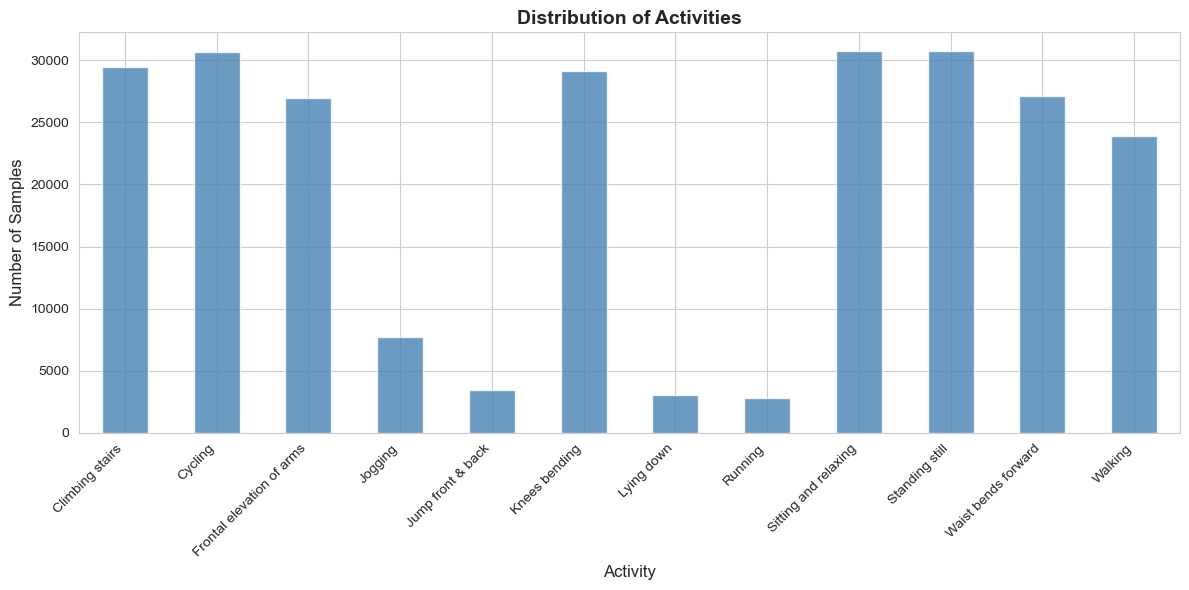

In [11]:
print("\n[4] EXPLORATORY DATA ANALYSIS")
print("-" * 80)

# Activity distribution
print("\nActivity Distribution:")
activity_counts = data_clean['activity_name'].value_counts().sort_index()
print(activity_counts)

# Visualize activity distribution
plt.figure(figsize=(12, 6))
activity_counts.plot(kind='bar', color='steelblue', alpha=0.8)
plt.title('Distribution of Activities', fontsize=14, fontweight='bold')
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [12]:
# Summary statistics by activity
print("\nDescriptive Statistics by Activity:")
print("=" * 80)

summary_stats = data_clean.groupby('activity_name').agg({
    'chest_acc_magnitude': ['count', 'mean', 'std', 'min', 'max'],
    'ankle_acc_magnitude': ['mean', 'std'],
    'heart_rate_estimate': ['mean', 'std']
}).round(3)

print(summary_stats)

# Save to CSV for easy viewing
summary_stats.to_csv('activity_summary_statistics.csv')
print("\n✓ Summary statistics saved to 'activity_summary_statistics.csv'")


Descriptive Statistics by Activity:
                          chest_acc_magnitude                               \
                                        count   mean    std    min     max   
activity_name                                                                
Climbing stairs                         29487  9.778  2.099  3.119  20.066   
Cycling                                 30657  9.600  1.257  1.754  21.278   
Frontal elevation of arms               27004  9.798  0.327  6.984  12.281   
Jogging                                  7685  8.305  6.942  0.259  27.908   
Jump front & back                        3458  5.259  6.055  0.195  28.816   
Knees bending                           29106  9.584  2.013  1.227  21.514   
Lying down                               3072  9.681  0.117  9.249  10.238   
Running                                  2833  9.235  7.142  0.549  28.005   
Sitting and relaxing                    30720  9.749  0.178  8.484  12.470   
Standing still             

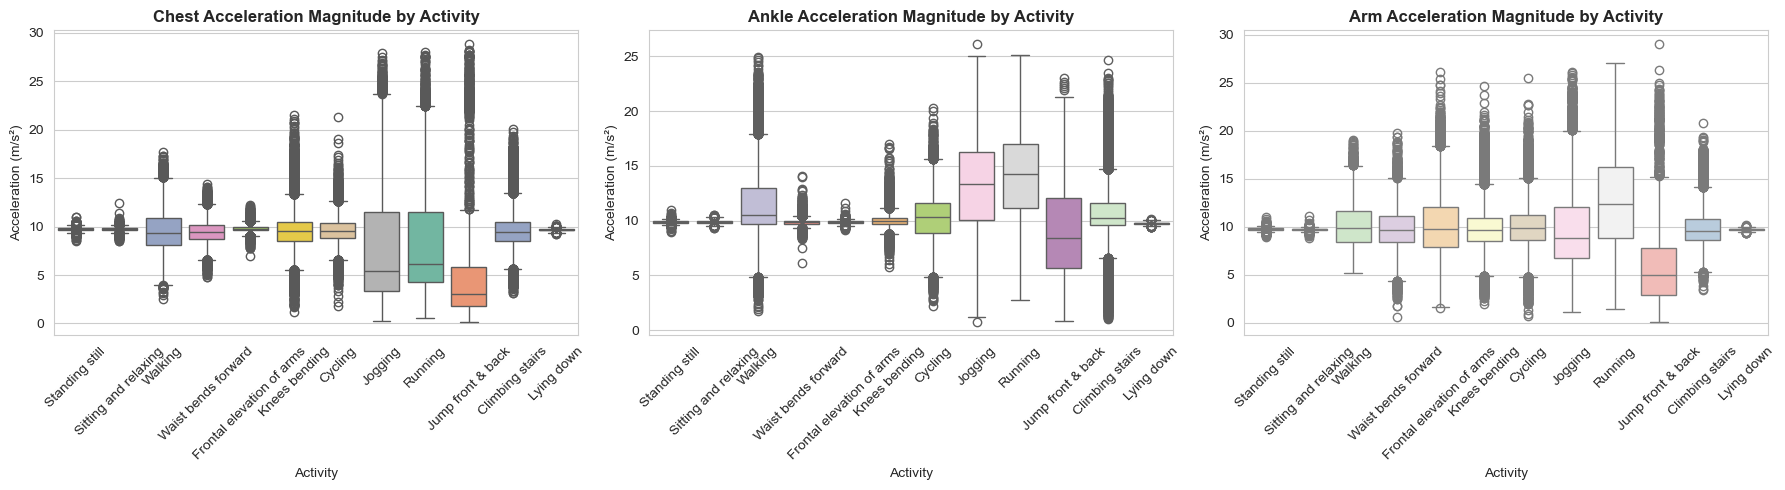

In [13]:
# Visualization: Acceleration Magnitude by Activity
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Chest acceleration
sns.boxplot(data=data_clean, x='activity_name', y='chest_acc_magnitude',
            palette='Set2', ax=axes[0])
axes[0].set_title('Chest Acceleration Magnitude by Activity', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Activity', fontsize=10)
axes[0].set_ylabel('Acceleration (m/s²)', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Ankle acceleration
sns.boxplot(data=data_clean, x='activity_name', y='ankle_acc_magnitude',
            palette='Set3', ax=axes[1])
axes[1].set_title('Ankle Acceleration Magnitude by Activity', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Activity', fontsize=10)
axes[1].set_ylabel('Acceleration (m/s²)', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

# Arm acceleration
sns.boxplot(data=data_clean, x='activity_name', y='arm_acc_magnitude',
            palette='Pastel1', ax=axes[2])
axes[2].set_title('Arm Acceleration Magnitude by Activity', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Activity', fontsize=10)
axes[2].set_ylabel('Acceleration (m/s²)', fontsize=10)
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

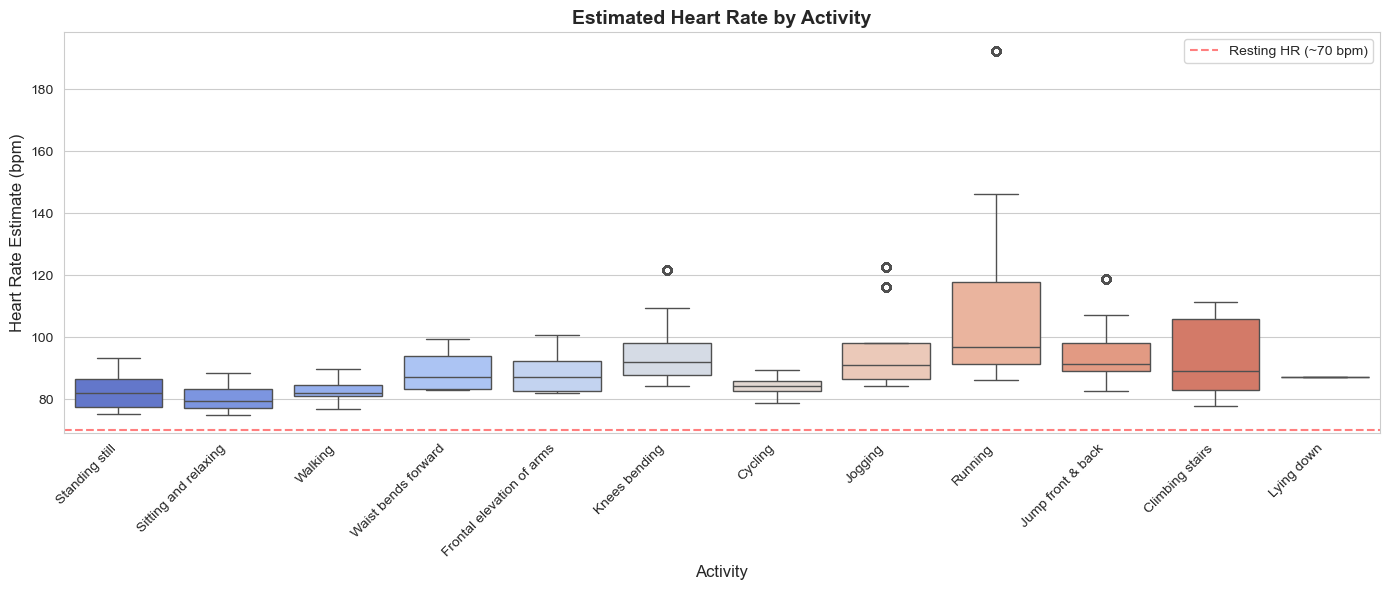

In [14]:
# Heart Rate by Activity
plt.figure(figsize=(14, 6))
sns.boxplot(data=data_clean, x='activity_name', y='heart_rate_estimate', palette='coolwarm')
plt.title('Estimated Heart Rate by Activity', fontsize=14, fontweight='bold')
plt.xlabel('Activity', fontsize=12)
plt.ylabel('Heart Rate Estimate (bpm)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Resting HR (~70 bpm)')
plt.legend()
plt.tight_layout()
plt.show()

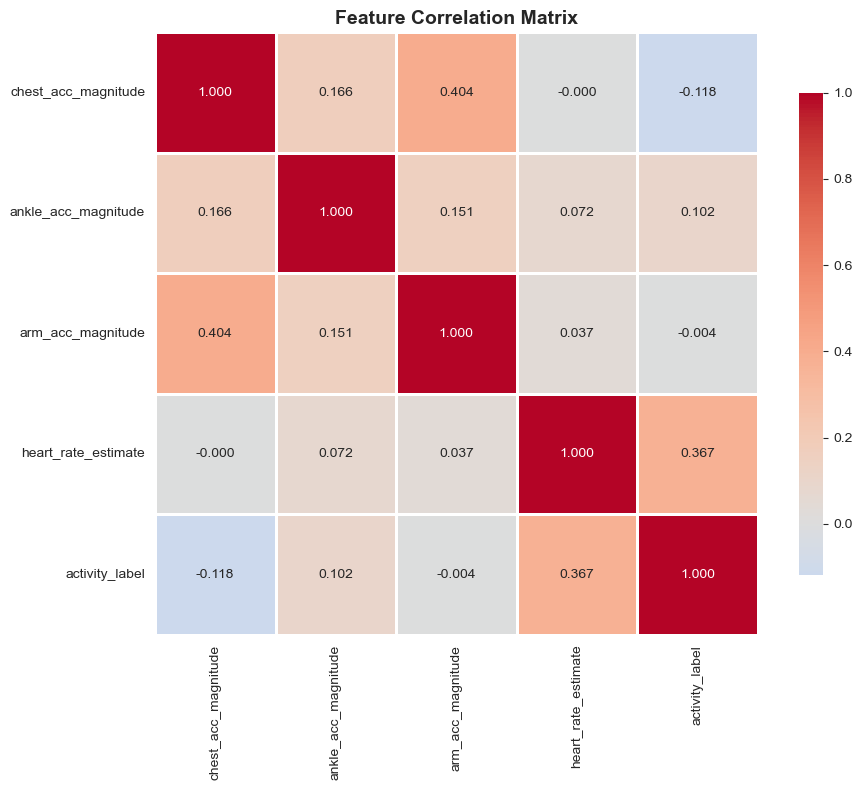


Correlation Insights:
                     chest_acc_magnitude  ankle_acc_magnitude  \
chest_acc_magnitude             1.000000             0.165851   
ankle_acc_magnitude             0.165851             1.000000   
arm_acc_magnitude               0.403667             0.151373   
heart_rate_estimate            -0.000336             0.072454   
activity_label                 -0.118139             0.102374   

                     arm_acc_magnitude  heart_rate_estimate  activity_label  
chest_acc_magnitude           0.403667            -0.000336       -0.118139  
ankle_acc_magnitude           0.151373             0.072454        0.102374  
arm_acc_magnitude             1.000000             0.036884       -0.004316  
heart_rate_estimate           0.036884             1.000000        0.367005  
activity_label               -0.004316             0.367005        1.000000  


In [15]:
# Correlation heatmap
plt.figure(figsize=(10, 8))

corr_features = ['chest_acc_magnitude', 'ankle_acc_magnitude', 'arm_acc_magnitude',
                 'heart_rate_estimate', 'activity_label']

correlation = data_clean[corr_features].corr()

sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0,
            fmt='.3f', square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation Insights:")
print(correlation)

In [16]:
print("\n[5] HYPOTHESIS TESTING")
print("=" * 80)

# Select specific activities for testing
# We'll compare different intensity levels
test_activities = ['Walking', 'Jogging', 'Running', 'Sitting and relaxing',
                   'Standing still', 'Cycling']

data_test = data_clean[data_clean['activity_name'].isin(test_activities)].copy()

print(f"Selected {len(data_test):,} samples from {len(test_activities)} activities for testing")
print(f"\nActivities included: {test_activities}")
print(f"\nSample distribution:")
print(data_test['activity_name'].value_counts())


[5] HYPOTHESIS TESTING
Selected 126,549 samples from 6 activities for testing

Activities included: ['Walking', 'Jogging', 'Running', 'Sitting and relaxing', 'Standing still', 'Cycling']

Sample distribution:
activity_name
Standing still          30720
Sitting and relaxing    30720
Cycling                 30657
Walking                 23934
Jogging                  7685
Running                  2833
Name: count, dtype: int64


In [17]:
print("\n[TEST 1] Independent T-Test: High Intensity vs Low Intensity Activities")
print("-" * 80)

# Define activity groups
high_intensity = ['Jogging', 'Running']
low_intensity = ['Sitting and relaxing', 'Standing still']

high_intensity_data = data_test[data_test['activity_name'].isin(high_intensity)]
low_intensity_data = data_test[data_test['activity_name'].isin(low_intensity)]

print(f"\nHigh Intensity Activities: {high_intensity}")
print(f"  Sample size: {len(high_intensity_data):,}")
print(f"\nLow Intensity Activities: {low_intensity}")
print(f"  Sample size: {len(low_intensity_data):,}")

# T-test for chest acceleration magnitude
print("\n" + "="*60)
print("CHEST ACCELERATION MAGNITUDE")
print("="*60)

t_stat_chest, p_value_chest = ttest_ind(
    high_intensity_data['chest_acc_magnitude'],
    low_intensity_data['chest_acc_magnitude']
)

high_mean_chest = high_intensity_data['chest_acc_magnitude'].mean()
low_mean_chest = low_intensity_data['chest_acc_magnitude'].mean()
high_std_chest = high_intensity_data['chest_acc_magnitude'].std()
low_std_chest = low_intensity_data['chest_acc_magnitude'].std()

print(f"High Intensity: Mean = {high_mean_chest:.3f} m/s², SD = {high_std_chest:.3f}")
print(f"Low Intensity:  Mean = {low_mean_chest:.3f} m/s², SD = {low_std_chest:.3f}")
print(f"Difference:     {high_mean_chest - low_mean_chest:.3f} m/s²")
print(f"\nT-statistic: {t_stat_chest:.4f}")
print(f"P-value: {p_value_chest:.6f}")
print(f"Significance: {'***SIGNIFICANT***' if p_value_chest < 0.05 else 'NOT SIGNIFICANT'} (α = 0.05)")

if p_value_chest < 0.001:
    print("Effect: Highly significant (p < 0.001)")
elif p_value_chest < 0.01:
    print("Effect: Very significant (p < 0.01)")
elif p_value_chest < 0.05:
    print("Effect: Significant (p < 0.05)")

# Cohen's d effect size
pooled_std = np.sqrt(((len(high_intensity_data)-1)*high_std_chest**2 +
                       (len(low_intensity_data)-1)*low_std_chest**2) /
                      (len(high_intensity_data) + len(low_intensity_data) - 2))
cohens_d = (high_mean_chest - low_mean_chest) / pooled_std
print(f"Cohen's d (effect size): {cohens_d:.3f}")
if abs(cohens_d) < 0.2:
    print("  → Small effect")
elif abs(cohens_d) < 0.5:
    print("  → Medium effect")
else:
    print("  → Large effect")


[TEST 1] Independent T-Test: High Intensity vs Low Intensity Activities
--------------------------------------------------------------------------------

High Intensity Activities: ['Jogging', 'Running']
  Sample size: 10,518

Low Intensity Activities: ['Sitting and relaxing', 'Standing still']
  Sample size: 61,440

CHEST ACCELERATION MAGNITUDE
High Intensity: Mean = 8.556 m/s², SD = 7.008
Low Intensity:  Mean = 9.757 m/s², SD = 0.168
Difference:     -1.201 m/s²

T-statistic: -42.4104
P-value: 0.000000
Significance: ***SIGNIFICANT*** (α = 0.05)
Effect: Highly significant (p < 0.001)
Cohen's d (effect size): -0.448
  → Medium effect


In [18]:
# T-test for heart rate estimate
print("\n" + "="*60)
print("HEART RATE ESTIMATE")
print("="*60)

t_stat_hr, p_value_hr = ttest_ind(
    high_intensity_data['heart_rate_estimate'],
    low_intensity_data['heart_rate_estimate']
)

high_mean_hr = high_intensity_data['heart_rate_estimate'].mean()
low_mean_hr = low_intensity_data['heart_rate_estimate'].mean()
high_std_hr = high_intensity_data['heart_rate_estimate'].std()
low_std_hr = low_intensity_data['heart_rate_estimate'].std()

print(f"High Intensity: Mean = {high_mean_hr:.1f} bpm, SD = {high_std_hr:.1f}")
print(f"Low Intensity:  Mean = {low_mean_hr:.1f} bpm, SD = {low_std_hr:.1f}")
print(f"Difference:     {high_mean_hr - low_mean_hr:.1f} bpm")
print(f"\nT-statistic: {t_stat_hr:.4f}")
print(f"P-value: {p_value_hr:.6f}")
print(f"Significance: {'***SIGNIFICANT***' if p_value_hr < 0.05 else 'NOT SIGNIFICANT'} (α = 0.05)")

# Effect size
pooled_std_hr = np.sqrt(((len(high_intensity_data)-1)*high_std_hr**2 +
                          (len(low_intensity_data)-1)*low_std_hr**2) /
                         (len(high_intensity_data) + len(low_intensity_data) - 2))
cohens_d_hr = (high_mean_hr - low_mean_hr) / pooled_std_hr
print(f"Cohen's d (effect size): {cohens_d_hr:.3f}")


HEART RATE ESTIMATE
High Intensity: Mean = 97.7 bpm, SD = 17.7
Low Intensity:  Mean = 81.5 bpm, SD = 5.1
Difference:     16.2 bpm

T-statistic: 186.6737
P-value: 0.000000
Significance: ***SIGNIFICANT*** (α = 0.05)
Cohen's d (effect size): 1.970


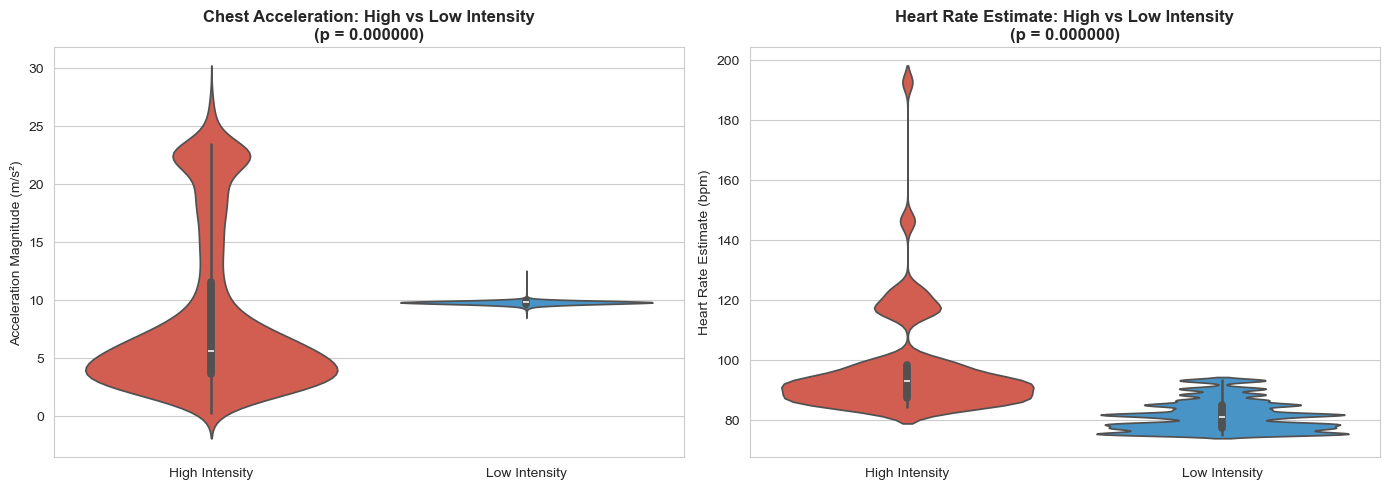

In [19]:
# Visualize T-test results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Acceleration comparison
data_ttest = pd.concat([
    high_intensity_data[['chest_acc_magnitude']].assign(Group='High Intensity'),
    low_intensity_data[['chest_acc_magnitude']].assign(Group='Low Intensity')
])

sns.violinplot(data=data_ttest, x='Group', y='chest_acc_magnitude',
               palette=['#e74c3c', '#3498db'], ax=axes[0])
axes[0].set_title(f'Chest Acceleration: High vs Low Intensity\n(p = {p_value_chest:.6f})',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Acceleration Magnitude (m/s²)', fontsize=10)
axes[0].set_xlabel('')

# Heart rate comparison
data_ttest_hr = pd.concat([
    high_intensity_data[['heart_rate_estimate']].assign(Group='High Intensity'),
    low_intensity_data[['heart_rate_estimate']].assign(Group='Low Intensity')
])

sns.violinplot(data=data_ttest_hr, x='Group', y='heart_rate_estimate',
               palette=['#e74c3c', '#3498db'], ax=axes[1])
axes[1].set_title(f'Heart Rate Estimate: High vs Low Intensity\n(p = {p_value_hr:.6f})',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Heart Rate Estimate (bpm)', fontsize=10)
axes[1].set_xlabel('')

plt.tight_layout()
plt.show()

In [20]:
print("\n[TEST 2] One-Way ANOVA: Multiple Activity Comparison")
print("-" * 80)

# Select activities for ANOVA
anova_activities = ['Walking', 'Jogging', 'Running', 'Sitting and relaxing', 'Cycling']
anova_data = data_test[data_test['activity_name'].isin(anova_activities)]

print(f"Comparing {len(anova_activities)} activities:")
for activity in anova_activities:
    count = len(anova_data[anova_data['activity_name'] == activity])
    print(f"  - {activity}: {count:,} samples")

# ANOVA for chest acceleration magnitude
print("\n" + "="*60)
print("ANOVA: CHEST ACCELERATION MAGNITUDE")
print("="*60)

groups_acc = [group['chest_acc_magnitude'].values
              for name, group in anova_data.groupby('activity_name')]

f_stat_acc, p_value_anova_acc = f_oneway(*groups_acc)

print(f"\nF-statistic: {f_stat_acc:.4f}")
print(f"P-value: {p_value_anova_acc:.8f}")
print(f"Result: {'***SIGNIFICANT***' if p_value_anova_acc < 0.05 else 'NOT SIGNIFICANT'} (α = 0.05)")

# Calculate means for each activity
print("\nMean chest acceleration by activity:")
for activity in anova_activities:
    act_data = anova_data[anova_data['activity_name'] == activity]
    mean_val = act_data['chest_acc_magnitude'].mean()
    std_val = act_data['chest_acc_magnitude'].std()
    print(f"  {activity:.<30} {mean_val:.3f} ± {std_val:.3f} m/s²")


[TEST 2] One-Way ANOVA: Multiple Activity Comparison
--------------------------------------------------------------------------------
Comparing 5 activities:
  - Walking: 23,934 samples
  - Jogging: 7,685 samples
  - Running: 2,833 samples
  - Sitting and relaxing: 30,720 samples
  - Cycling: 30,657 samples

ANOVA: CHEST ACCELERATION MAGNITUDE

F-statistic: 479.4757
P-value: 0.00000000
Result: ***SIGNIFICANT*** (α = 0.05)

Mean chest acceleration by activity:
  Walking....................... 9.604 ± 2.160 m/s²
  Jogging....................... 8.305 ± 6.942 m/s²
  Running....................... 9.235 ± 7.142 m/s²
  Sitting and relaxing.......... 9.749 ± 0.178 m/s²
  Cycling....................... 9.600 ± 1.257 m/s²


In [21]:
# Post-hoc analysis: Pairwise comparisons
if p_value_anova_acc < 0.05:
    print("\n" + "="*60)
    print("POST-HOC ANALYSIS: Pairwise T-Tests (Acceleration)")
    print("="*60)
    print("(Bonferroni correction applied for multiple comparisons)")

    activity_pairs = list(combinations(anova_activities, 2))
    n_comparisons = len(activity_pairs)
    bonferroni_alpha = 0.05 / n_comparisons

    print(f"\nNumber of comparisons: {n_comparisons}")
    print(f"Bonferroni-corrected α: {bonferroni_alpha:.6f}\n")

    pairwise_results = []

    for act1, act2 in activity_pairs:
        group1 = anova_data[anova_data['activity_name'] == act1]['chest_acc_magnitude']
        group2 = anova_data[anova_data['activity_name'] == act2]['chest_acc_magnitude']

        t_stat, p_val = ttest_ind(group1, group2)

        # Determine significance with Bonferroni correction
        if p_val < bonferroni_alpha:
            sig = "***"
            sig_text = "Significant (Bonferroni)"
        elif p_val < 0.05:
            sig = "*"
            sig_text = "Significant (uncorrected)"
        else:
            sig = "ns"
            sig_text = "Not significant"

        mean_diff = group1.mean() - group2.mean()

        pairwise_results.append({
            'Comparison': f"{act1} vs {act2}",
            'Mean Diff': mean_diff,
            'p-value': p_val,
            'Significance': sig_text
        })

        print(f"{act1:.<20} vs {act2:.<20} | "
              f"Δ={mean_diff:>7.3f} | p={p_val:.6f} {sig:>3}")

    # Create results DataFrame
    pairwise_df = pd.DataFrame(pairwise_results)
    pairwise_df.to_csv('pairwise_comparisons.csv', index=False)
    print("\n✓ Pairwise comparison results saved to 'pairwise_comparisons.csv'")


POST-HOC ANALYSIS: Pairwise T-Tests (Acceleration)
(Bonferroni correction applied for multiple comparisons)

Number of comparisons: 10
Bonferroni-corrected α: 0.005000

Walking............. vs Jogging............. | Δ=  1.299 | p=0.000000 ***
Walking............. vs Running............. | Δ=  0.370 | p=0.000000 ***
Walking............. vs Sitting and relaxing | Δ= -0.145 | p=0.000000 ***
Walking............. vs Cycling............. | Δ=  0.004 | p=0.791952  ns
Jogging............. vs Running............. | Δ= -0.929 | p=0.000000 ***
Jogging............. vs Sitting and relaxing | Δ= -1.444 | p=0.000000 ***
Jogging............. vs Cycling............. | Δ= -1.295 | p=0.000000 ***
Running............. vs Sitting and relaxing | Δ= -0.514 | p=0.000000 ***
Running............. vs Cycling............. | Δ= -0.366 | p=0.000000 ***
Sitting and relaxing vs Cycling............. | Δ=  0.149 | p=0.000000 ***

✓ Pairwise comparison results saved to 'pairwise_comparisons.csv'


In [23]:
#  Run ANOVA tests before plotting

# Group data for ANOVA
anova_groups_acc = [group["chest_acc_magnitude"].dropna() for _, group in anova_data.groupby("activity_name")]
anova_groups_hr = [group["heart_rate_estimate"].dropna() for _, group in anova_data.groupby("activity_name")]

# Perform ANOVA for both variables
f_stat_acc, p_value_anova_acc = stats.f_oneway(*anova_groups_acc)
f_stat_hr, p_value_anova_hr = stats.f_oneway(*anova_groups_hr)

# Print results to confirm
print("ANOVA Results:")
print(f"Acceleration Magnitude → F = {f_stat_acc:.4f}, p = {p_value_anova_acc:.6f}")
print(f"Heart Rate Estimate   → F = {f_stat_hr:.4f}, p = {p_value_anova_hr:.6f}")


ANOVA Results:
Acceleration Magnitude → F = 479.4757, p = 0.000000
Heart Rate Estimate   → F = 15599.5486, p = 0.000000



[ADDITIONAL ANALYSIS] Inter-Subject Variation
--------------------------------------------------------------------------------


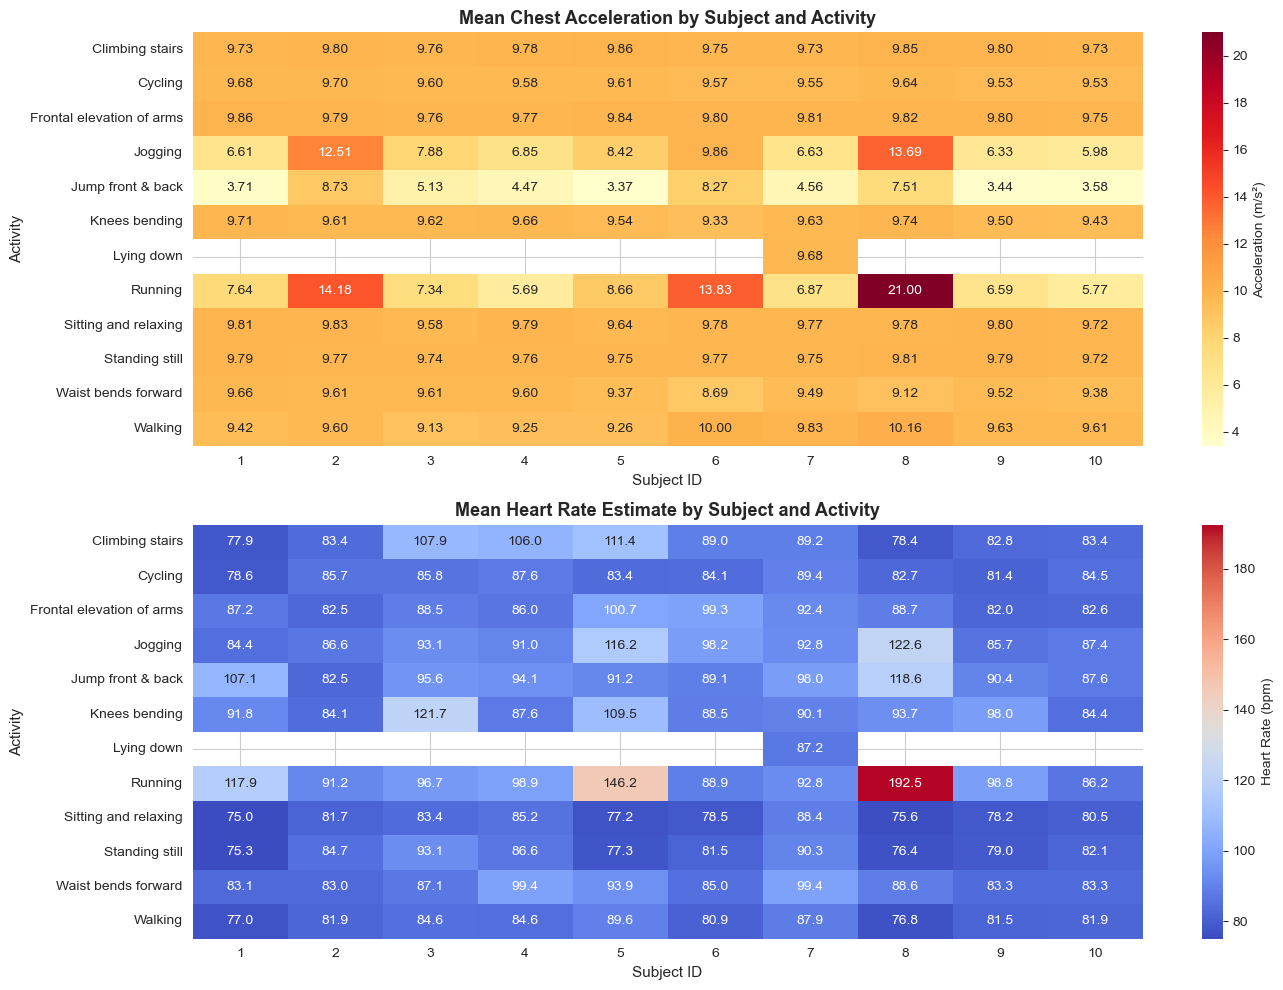


Coefficient of Variation (CV) across subjects:
                           chest_acc_magnitude
activity_name                                 
Climbing stairs                          21.46
Cycling                                  13.10
Frontal elevation of arms                 3.33
Jogging                                  83.58
Jump front & back                       115.14
Knees bending                            21.00
Lying down                                1.21
Running                                  77.34
Sitting and relaxing                      1.83
Standing still                            1.60
Waist bends forward                      12.50
Walking                                  22.49


In [24]:
# Analyze variation across subjects
print("\n[ADDITIONAL ANALYSIS] Inter-Subject Variation")
print("-" * 80)

# Calculate mean acceleration per subject per activity
subject_activity_means = data_clean.groupby(['subject_id', 'activity_name']).agg({
    'chest_acc_magnitude': 'mean',
    'heart_rate_estimate': 'mean'
}).reset_index()

# Visualize subject variation
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Acceleration by subject
subject_pivot_acc = subject_activity_means.pivot(
    index='activity_name',
    columns='subject_id',
    values='chest_acc_magnitude'
)

sns.heatmap(subject_pivot_acc, annot=True, fmt='.2f', cmap='YlOrRd',
            cbar_kws={'label': 'Acceleration (m/s²)'}, ax=axes[0])
axes[0].set_title('Mean Chest Acceleration by Subject and Activity',
                  fontsize=13, fontweight='bold')
axes[0].set_xlabel('Subject ID', fontsize=11)
axes[0].set_ylabel('Activity', fontsize=11)

# Heart rate by subject
subject_pivot_hr = subject_activity_means.pivot(
    index='activity_name',
    columns='subject_id',
    values='heart_rate_estimate'
)

sns.heatmap(subject_pivot_hr, annot=True, fmt='.1f', cmap='coolwarm',
            cbar_kws={'label': 'Heart Rate (bpm)'}, ax=axes[1])
axes[1].set_title('Mean Heart Rate Estimate by Subject and Activity',
                  fontsize=13, fontweight='bold')
axes[1].set_xlabel('Subject ID', fontsize=11)
axes[1].set_ylabel('Activity', fontsize=11)

plt.tight_layout()
plt.show()

# Calculate coefficient of variation
print("\nCoefficient of Variation (CV) across subjects:")
cv_by_activity = data_clean.groupby('activity_name').agg({
    'chest_acc_magnitude': lambda x: (x.std() / x.mean()) * 100
}).round(2)
print(cv_by_activity)

In [25]:
print("\n" + "=" * 80)
print

<function print(*args, sep=' ', end='\n', file=None, flush=False)>